In [4]:
import pandas as pd
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_grid, stat_summary,
    theme, element_text, theme_bw
)
from plotnine.scales import scale_y_log10, scale_x_log10
import os

In [71]:
dfs = []
pretrain: str="1,1,1,1,1"
sft: str="1,0,0,0,0"
layers: str="1,2,3,4,8,12,16"
for layer in layers.split(","):
    # set up dir
    directory = f"figs/{pretrain}-{sft}/"
    if os.path.exists(f"{directory}/all_law_params-{layer}-sft.csv"):
        # load data
        data = pd.read_csv(f"{directory}/all_law_params-{layer}-sft.csv")
        data['layers'] = int(layer)
        dfs.append(data)
    else:
        print(f"File {directory}/all_law_params-{layer}-sft.csv does not exist")

# format df
df_all = pd.concat(dfs)
order = list(map(str, sorted(df_all['layers'].unique())))
df_all['layers'] = pd.Categorical(df_all['layers'].astype(str), categories=order, ordered=True)

# drop sft_amount == "none"
df_all = df_all[df_all['sft_amount'] != "none"]
df_all['sft_amount'] = df_all['sft_amount'].astype(float)

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


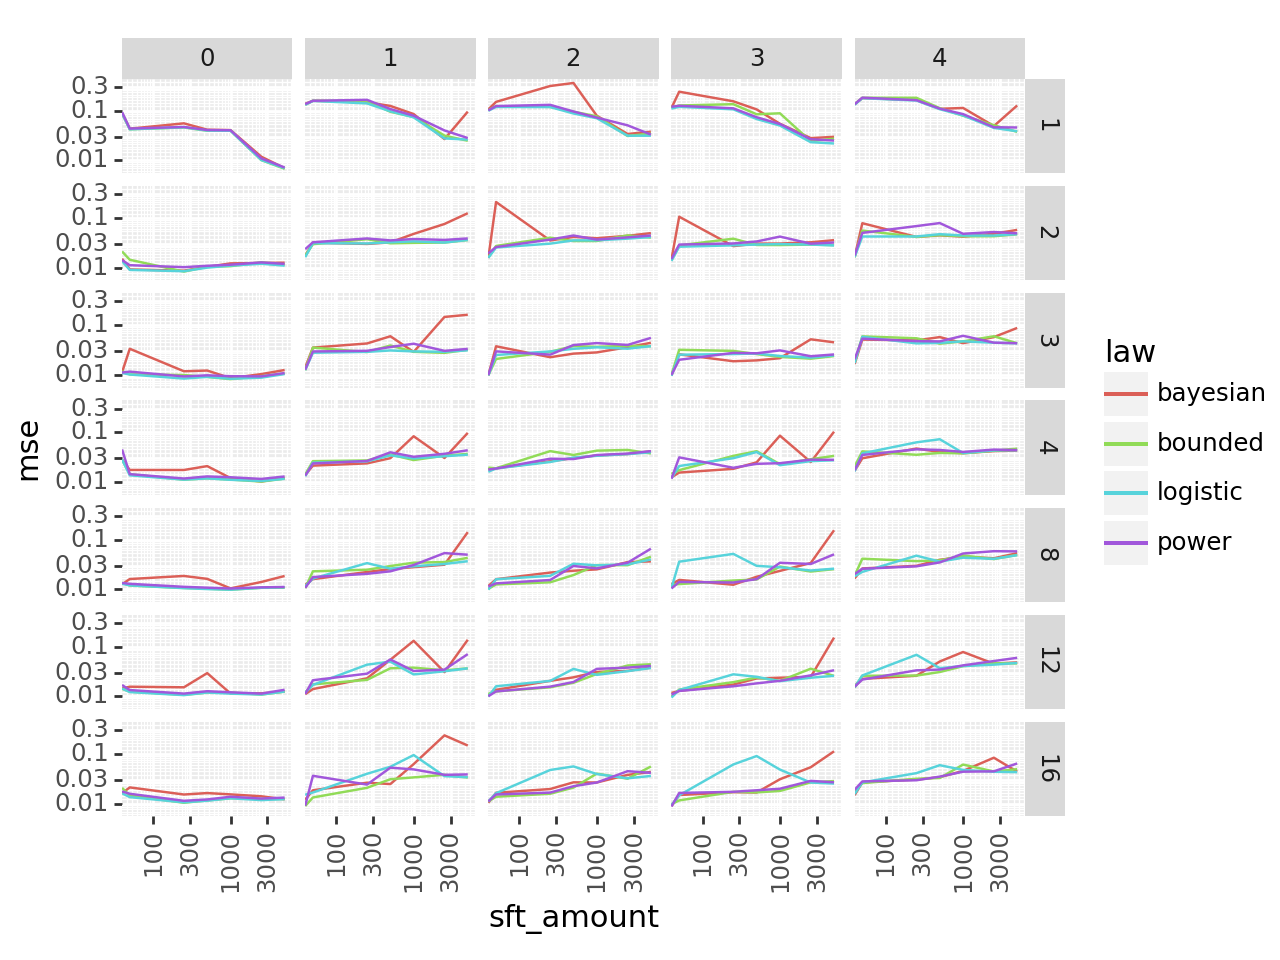

In [83]:
plot = (
    ggplot(df_all[(df_all["k"] == 3)], aes(x='sft_amount', y='mse', color='law')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("layers~hmm") + scale_x_log10() + scale_y_log10()
)
print(plot)

In [41]:
df_all = df_all[df_all['law'] == 'bayesian']
df_all

,sft_amount,k,hmm,law,priors,gammas,betas,K,mse,C,alpha,n_c,layers
0,0.0,3,0,bayesian,0.019674,0.147148,0.125671,1.845644,0.088883,NaN,NaN,NaN,1
1,0.0,3,1,bayesian,0.239009,0.214668,0.121395,1.845644,0.137650,NaN,NaN,NaN,1
2,0.0,3,2,bayesian,0.397768,0.145471,0.161931,1.845644,0.106110,NaN,NaN,NaN,1
3,0.0,3,3,bayesian,0.250321,0.196507,0.105006,1.845644,0.113368,NaN,NaN,NaN,1
4,0.0,3,4,bayesian,0.093228,0.160974,0.116079,1.845644,0.135997,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,5000.0,10,0,bayesian,0.909116,0.475441,0.001569,0.001004,0.000601,NaN,NaN,NaN,16
541,5000.0,10,1,bayesian,0.000268,0.084418,0.071891,0.001004,0.036079,NaN,NaN,NaN,16
542,5000.0,10,2,bayesian,0.062650,0.150061,0.003313,0.001004,0.061002,NaN,NaN,NaN,16
543,5000.0,10,3,bayesian,0.015231,0.142806,0.004896,0.001004,0.031540,NaN,NaN,NaN,16


In [42]:
# df = pd.melt(df_all, id_vars=['sft_amount', 'k', 'hmm', 'layers'], value_vars=['gammas', 'betas'], var_name='metric', value_name='value')
from copy import deepcopy

df = deepcopy(df_all)
df['diff'] = df['gammas'] - df['betas']
df

,sft_amount,k,hmm,law,priors,gammas,betas,K,mse,C,alpha,n_c,layers,diff
0,0.0,3,0,bayesian,0.019674,0.147148,0.125671,1.845644,0.088883,NaN,NaN,NaN,1,0.021477
1,0.0,3,1,bayesian,0.239009,0.214668,0.121395,1.845644,0.137650,NaN,NaN,NaN,1,0.093272
2,0.0,3,2,bayesian,0.397768,0.145471,0.161931,1.845644,0.106110,NaN,NaN,NaN,1,-0.016460
3,0.0,3,3,bayesian,0.250321,0.196507,0.105006,1.845644,0.113368,NaN,NaN,NaN,1,0.091501
4,0.0,3,4,bayesian,0.093228,0.160974,0.116079,1.845644,0.135997,NaN,NaN,NaN,1,0.044895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,5000.0,10,0,bayesian,0.909116,0.475441,0.001569,0.001004,0.000601,NaN,NaN,NaN,16,0.473872
541,5000.0,10,1,bayesian,0.000268,0.084418,0.071891,0.001004,0.036079,NaN,NaN,NaN,16,0.012527
542,5000.0,10,2,bayesian,0.062650,0.150061,0.003313,0.001004,0.061002,NaN,NaN,NaN,16,0.146749
543,5000.0,10,3,bayesian,0.015231,0.142806,0.004896,0.001004,0.031540,NaN,NaN,NaN,16,0.137910


/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


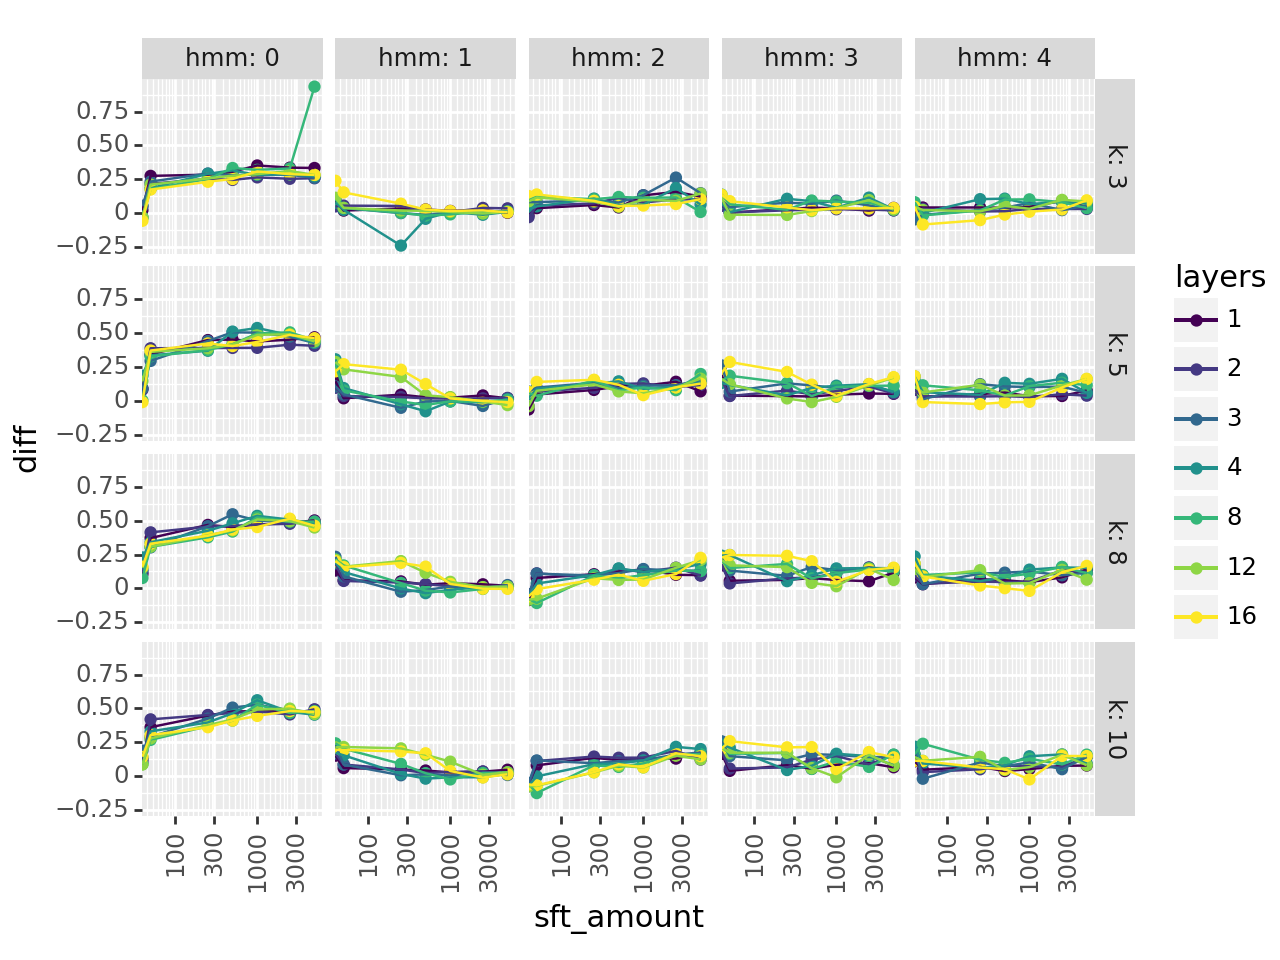

In [43]:
plot = (
    ggplot(df, aes(x='sft_amount', y='diff', color='layers')) + geom_point() +
    geom_line() + scale_x_log10() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("k~hmm", labeller="label_both")
)
print(plot)

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


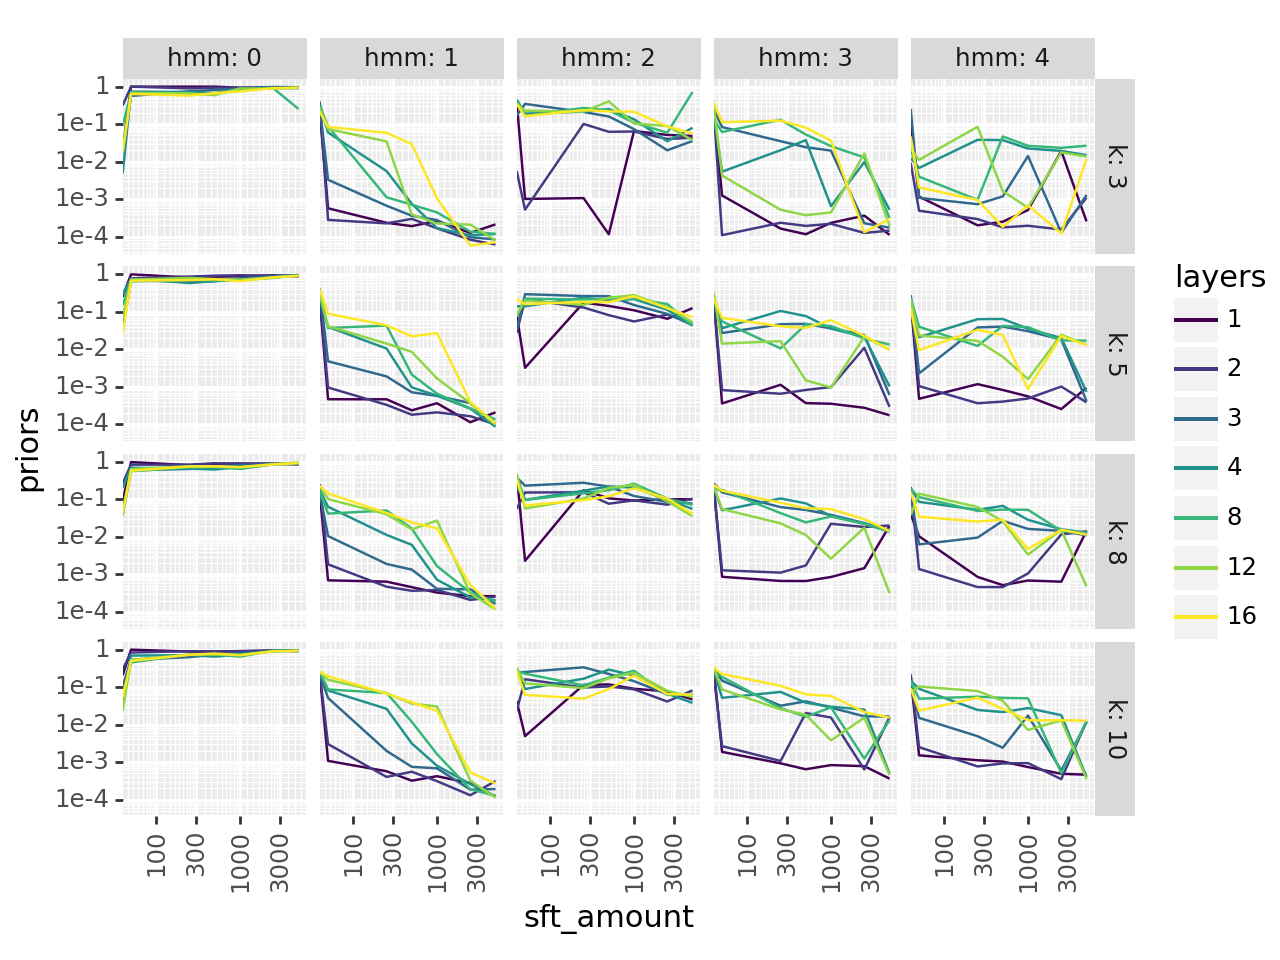

In [45]:
plot = (
    ggplot(df, aes(x='sft_amount', y='priors', color='layers')) +
    geom_line() + scale_x_log10() + theme(axis_text_x=element_text(rotation=90)) +
    scale_y_log10() +
    facet_grid("k~hmm", labeller="label_both")
)
print(plot)

In [52]:
import math

def inv_sigmoid(x):
    return -math.log((1-x)/x)

In [61]:
df['gammas_s'] = df.apply(lambda x: inv_sigmoid(x['gammas']), axis=1)
df

,sft_amount,k,hmm,law,priors,gammas,betas,K,mse,C,alpha,n_c,layers,diff,priors_s,gammas_s
0,0.0,3,0,bayesian,0.019674,0.147148,0.125671,1.845644,0.088883,NaN,NaN,NaN,1,0.021477,-3.908595,-1.757148
1,0.0,3,1,bayesian,0.239009,0.214668,0.121395,1.845644,0.137650,NaN,NaN,NaN,1,0.093272,-1.158121,-1.297016
2,0.0,3,2,bayesian,0.397768,0.145471,0.161931,1.845644,0.106110,NaN,NaN,NaN,1,-0.016460,-0.414775,-1.770577
3,0.0,3,3,bayesian,0.250321,0.196507,0.105006,1.845644,0.113368,NaN,NaN,NaN,1,0.091501,-1.096900,-1.408269
4,0.0,3,4,bayesian,0.093228,0.160974,0.116079,1.845644,0.135997,NaN,NaN,NaN,1,0.044895,-2.274838,-1.650999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,5000.0,10,0,bayesian,0.909116,0.475441,0.001569,0.001004,0.000601,NaN,NaN,NaN,16,0.473872,2.302886,-0.098315
541,5000.0,10,1,bayesian,0.000268,0.084418,0.071891,0.001004,0.036079,NaN,NaN,NaN,16,0.012527,-8.222541,-2.383776
542,5000.0,10,2,bayesian,0.062650,0.150061,0.003313,0.001004,0.061002,NaN,NaN,NaN,16,0.146749,-2.705491,-1.734120
543,5000.0,10,3,bayesian,0.015231,0.142806,0.004896,0.001004,0.031540,NaN,NaN,NaN,16,0.137910,-4.169082,-1.792177


/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


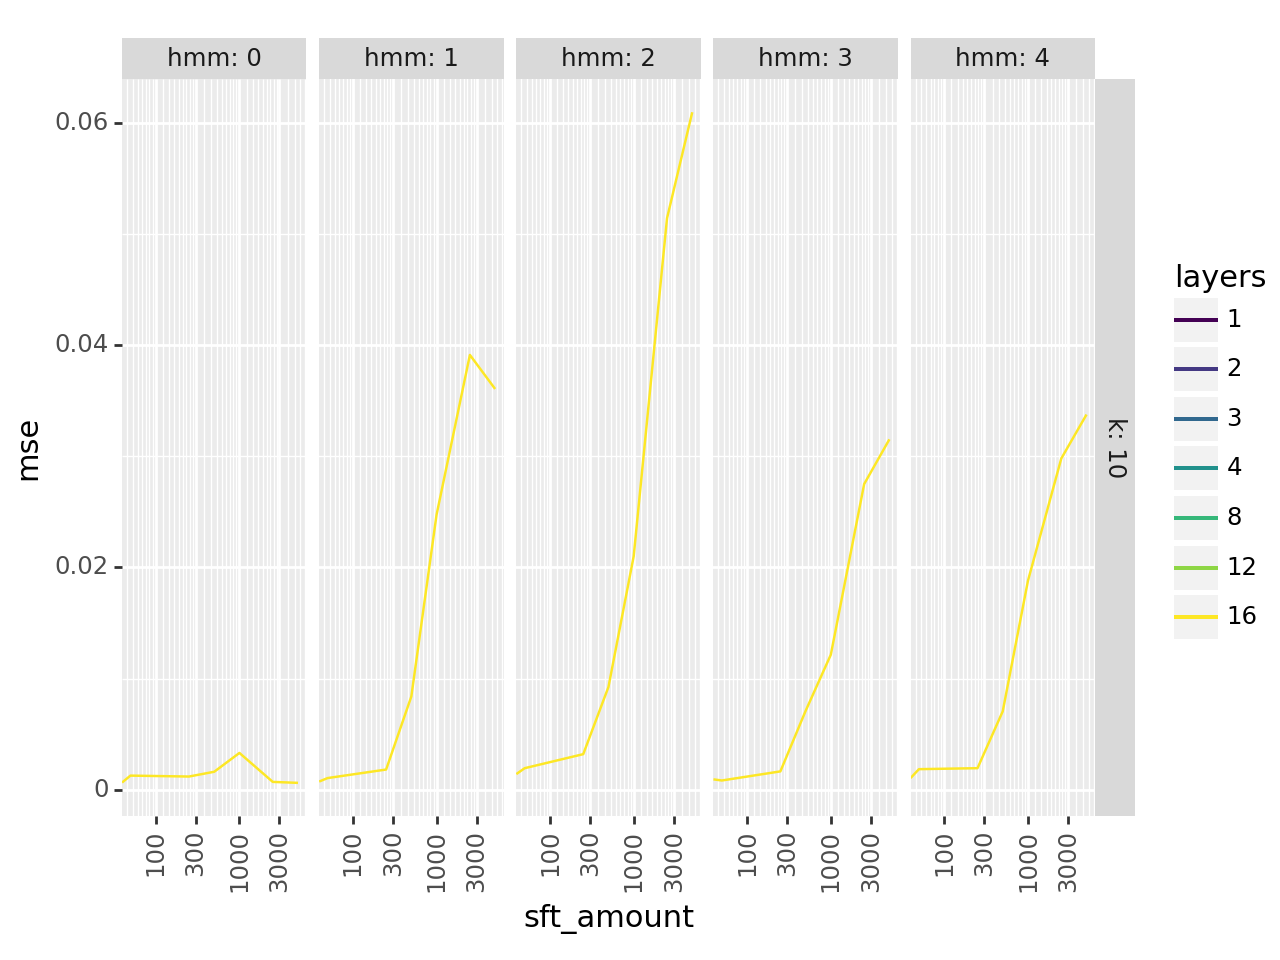

In [70]:
plot = (
    ggplot(df[(df["layers"] == '16') & (df["k"] == 10)], aes(x='sft_amount', y='mse', color='layers')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("k~hmm", labeller="label_both") + scale_x_log10()
)
print(plot)